## Texture vs Shape: introduction
(homework #2 for DNN 2024/25)

<div style="max-width: 60em">

In this homework, we will look at a modern residual convolutional net. While they perform very well on image classification tasks, some problems they commonly have are that:<br>
* they rely too much on small-scale features (textures) rather than large-scale ones (shape). This often generalizes poorly to unseen datasets and is less human-aligned (e.g. explanations of why a model chose this class may be less interpretable).
* they are very susceptible to adversarial images, i.e. inputs maliciously altered in a way that is imperceptible to humans and shouldn't change the classification, but completely fool the model, making it output high probabilities for unrelated classes.

While the two problems are somewhat related, we focus on the first one.
You are given a pre-trained model and datasets, as well as the code for standard evaluation and training loops, and for generating adversarial examples.
Your tasks (fully detailed in later cells) will be as follows:

0. Adapt a pretrained model to the smaller datasets by changing the classification layer.
1. Implement transformations (blur, pixelize, noise) that can help us elucidate and perhaps remedy the texture-bias problem.
2. Compare how the model handles them and how much they help as augmentations used in fine-tuning.
3. Read a paper about AdvProp: a relatively simple method for training models with less texture bias, using adversarial examples; implement and evaluate it.
4. Implement and evaluate SparseTopK: another, even simpler method proposed for the same problem: it just zeroes all but the top 20% activations in some layers.

Submission requirements:
* Please do not modify anything outside of the `### BEGIN SOLUTION ... ### END SOLUTION` blocks (if you feel it might be useful somewhere, ask on slack).
* Please make sure to submit your solution as a notebook with saved cell outputs.
* Don't use `tqdm.notebook` or `tqdm.auto`, just plain `tqdm`.
* It should be possible to execute the notebook from top to bottom when loaded in Colab with a GPU, in a reasonable amount of time.
* Plots should either be images embedded in cell outputs (in a way that shows correctly when loading the notebook from file, without executing it), or attached together with the exported .ipynb notebook in a .zip file  (screenshots are admissible, but prefer exporting with e.g. `plt.savefig()`).

</div>

## Imports

In [ ]:
import json
import multiprocessing
from collections.abc import Callable, Iterable, Sequence
from copy import deepcopy
from functools import partial
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models
import torch.optim.lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

### BEGIN SOLUTION
# Feel free to add more imports and global settings here, though none are necessary.
import functools
import itertools
import seaborn as sns
### END SOLUTION

%matplotlib inline

multiprocessing.set_start_method("spawn", force=True)  # Needed when using CUDA.
torch.set_num_threads(8)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    torch.cuda.set_device(2)

_ = torch.manual_seed(42)

## Datasets

In [ ]:
%%bash
# 219 MiB
if [ ! -d datasets ]; then
    gdown https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg \
        && tar -xf datasets.tar.gz \
        && rm datasets.tar.gz
fi

Downloading...
From (original): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg
From (redirected): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg&confirm=t&uuid=a778ca17-86eb-4d32-ba83-4d8379f574cf
To: /content/datasets.tar.gz
100%|██████████| 229M/229M [00:01<00:00, 159MB/s]


##### MiniImageNet
MiniImageNet is a downscaled subset of ISVLRC ImageNet-1k<sup>[1]</sup> with only 10 classes (RGB, irregular sizes up to 256x256).
Train/val is a uniformly random split, the parts have 2000/100 images per class, respectively.

We will use the *train* part for fine-tuning and *val* for validation and various evaluation.

[1] https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview

['bear', 'bicycle', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'elephant', 'truck']


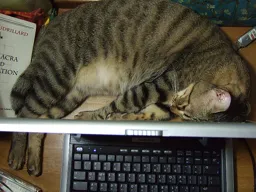

In [ ]:
MINI_IMAGENET_PATH = Path("datasets/miniImageNet")
SELECTED_CLASSES = ImageFolder(MINI_IMAGENET_PATH / "train").classes
assert SELECTED_CLASSES == ImageFolder(MINI_IMAGENET_PATH / "val").classes


def example() -> None:  # Note: we scope examples to avoid polluting the global namespace.
    print(SELECTED_CLASSES)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val")
    img, label = dataset[505]
    display(img)
    print(label, dataset.classes[label])


example()

##### eval_transform, display_image_tensor()

5 cat


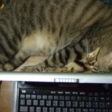

img.shape=torch.Size([3, 112, 112]), img.dtype=torch.float32, min..max=-2.015..2.64
label=5 (cat)


In [ ]:
def get_eval_transform() -> v2.Compose:
    """
    The default transform used on all ImageNet images before passing to a model.

    (Typically papers end up with 224x224 images, we make them smaller for speed.)
    """
    return v2.Compose(
        [
            v2.PILToTensor(),
            v2.Resize(size=128, antialias=True),
            v2.CenterCrop(size=(112, 112)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ]
    )


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize an image tensor of shape (*B, C, H, W) from 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return (x - mean) / std


def unnormalize(x: torch.Tensor) -> torch.Tensor:
    """Revert an image tensor of shape (*B, C, H, W) to 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return x * std + mean


def display_image_tensor(x: torch.Tensor) -> None:
    """Display a normalized image tensor of shape (C, H, W) as a PIL Image."""
    pil_image: PIL.Image.Image = v2.ToPILImage()(unnormalize(x))
    display(pil_image)


def ceildiv(a: int, b: int) -> int:
    """Return ceil(a /b)."""
    return -(-a // b)


def example() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[505]
    display_image_tensor(img)
    print(f"{img.shape=}, {img.dtype=}, min..max={img.min().item():.4g}..{img.max().item():.4g}")
    print(f"{label=} ({dataset.classes[label]})")


example()

##### alt_test_dataset
This is a dataset with the same classes and some of the same images, but restylized or otherwise altered to mislead models reliant on textures.
We will use this dataset to test if a training method results in a model that is less reliant on textures.
Note that some alterations are pretty heavy, so the images look very different and it is difficult to achieve more than ~40-50% accuracy.

RGB, 224x224, 280 images per class.

(The dataset was created from https://github.com/bethgelab/model-vs-human/releases/tag/v0.1)

cue-conflict 800, edge 100, low-pass 800, silhouette 100, sketch 500, stylized 500, total 2800


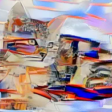

In [ ]:
ALT_TEST_DATASET_PATHS = sorted(Path("datasets/testSets").iterdir())
alt_test_dataset = ConcatDataset([ImageFolder(p, transform=get_eval_transform()) for p in ALT_TEST_DATASET_PATHS])


def example() -> None:
    for p in ALT_TEST_DATASET_PATHS:
        dataset = ImageFolder(p, transform=get_eval_transform())
        assert dataset.classes == SELECTED_CLASSES
        print(p.name, len(dataset), end=", ")
        # display_image_tensor(dataset[int(len(dataset) * 0.53)][0])
    print("total", len(alt_test_dataset))

    img, _label = alt_test_dataset[445]
    display_image_tensor(img)


example()

## Evaluate() and get_dataloader()

Here's an implementation of an evaluation loop, to be used in this notebook.

In [ ]:
def get_dataloader(
    dataset: Dataset,
    shuffle: bool = False,
    batch_size: int = 256,
    num_workers: int = 2,
    pin_memory: bool = True,
    prefetch_factor: int = 2,
    persistent_workers: bool = True,
    timeout: float = 30.0,
    **kwargs: Any,
) -> DataLoader:
    """DataLoader constructor with different defaults."""
    if num_workers == 0:
        pin_memory = False
        persistent_workers = False
        prefetch_factor = None
        timeout = 0.0

    return DataLoader(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers,
        timeout=timeout,
        **kwargs,
    )

In [ ]:
def evaluate(
    model: torch.nn.Module,
    dataloader: Dataset | DataLoader,
    description: str = "eval",
    device: str = DEVICE,
    quiet: bool = False,
    use_workers: bool = True,
) -> float:
    """Evaluate a model on a dataset or dataloader, returning the accuracy (0..1)."""
    model = model.to(device).eval()
    if not isinstance(dataloader, DataLoader):  # Create from dataset.
        if use_workers:
            dataloader = get_dataloader(dataloader, persistent_workers=False)
        else:
            dataloader = get_dataloader(dataloader, num_workers=0)

    accuracy, n_done, n_correct = 0, 0, 0

    progress_bar = tqdm(dataloader, desc=description, disable=quiet, delay=0.5)
    with torch.no_grad(), progress_bar:
        for image_batch, label_batch in progress_bar:
            logits_batch = model(image_batch.to(device))
            predictions = logits_batch.argmax(dim=1)

            n_done += len(label_batch)
            n_correct += (predictions == label_batch.to(device)).sum().item()
            accuracy = n_correct / n_done if n_done else 0
            progress_bar.set_postfix({"accuracy": f"{accuracy * 100:.1f} %"})

    return accuracy

## Task 0: Model, remapping the classification layer

We will use a ready-made model pretrained on ImageNet-1k.<br>
Since they all output logits for 1000 classes (`IMAGENET_CATEGORIES`),<br>
we need to alter the classification layer to output logits for the 10 MiniImageNet classes instead (`SELECTED_CLASSES`).<br>
Note that several ImageNet-1k classes can map to the same MiniImageNet class.<br>

Your task is to complete the implementation of `remap_output_layer()` below,<br>
so that the model works without any fine-tuning/training of the last layer.<br>
In `example_remapping()` below (which evaluates the model on the val dataset),<br>
you should achieve at least 70% accuracy and finish in under 35 seconds on Colab CPU (~15s on GPU).<br>

In [ ]:
SELECTED_MODEL = (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
# 5.3M params, 78% acc@1 on original ImageNet-1k

# Other models we considered, but cut for time:
# * (torchvision.models.mobilenet_v3_small, torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
#     2.5M params, 68% acc@1
# * (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
#     11.7M params, 70% acc@1 on original ImageNet-1k
# * (torchvision.models.efficientnet_v2_s, torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
#     21.5M params, 84% acc@1

IMAGENET_CATEGORIES = SELECTED_MODEL[1].meta["categories"]
assert IMAGENET_CATEGORIES == torchvision.models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
print(len(IMAGENET_CATEGORIES), ", ".join(IMAGENET_CATEGORIES[:7] + ["..."]))

1000 tench, goldfish, great white shark, tiger shark, hammerhead, electric ray, stingray, ...


In [ ]:
# Some technical details, feel free to ignore.


def _load_imagenet_id_to_class_id_map(classes: Sequence[str] = SELECTED_CLASSES) -> dict[int, int]:
    """
    Return a map from imagenet ids 0..999 to selected class ids: 0..len(classes)-1.

    Classes should be a subset of the following 16 class names:
        airplane,bear,bicycle,bird,boat,bottle,car,cat,chair,clock,dog,elephant,keyboard,knife,oven,truck
    """
    imagenet_id_to_name = {i: name for i, name in enumerate(IMAGENET_CATEGORIES)}
    class_to_idx = {name: i for i, name in enumerate(classes)}
    with open("datasets/imagenet_name_to_synset_id.json") as f:
        name_to_synset = json.load(f)
    with open("datasets/synset_id_to_class.json") as f:
        synset_to_class = json.load(f)
    # Not all synsets defined in synset_id_to_class.json are present in ImageNet-1k
    # (they also don't appear in our dataset 10-class-ImageNet).
    imagenet_name_to_class_name = {
        name: synset_to_class[synset] for name, synset in name_to_synset.items() if synset in synset_to_class
    }

    result = dict[int, int]()
    for imagenet_id, imagenet_name in imagenet_id_to_name.items():
        # Not all imagenet names are present in 10-class-ImageNet, obviously.
        if imagenet_name in imagenet_name_to_class_name:
            class_name = imagenet_name_to_class_name[imagenet_name]
            # Not all class names defined for 16-class-ImageNet are present in our dataset 10-class-ImageNet.
            if class_name in class_to_idx:
                result[imagenet_id] = class_to_idx[class_name]

    for k, v in result.items():
        assert 0 <= k < len(IMAGENET_CATEGORIES) and 0 <= v < len(classes)

    return result


def _reset_model_weights(model: torch.nn.Module) -> None:
    """Reinitialize the model weights randomly. We probably won't use it."""
    # Some models define reset_parameters(), but unfortunately not all.
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d | torch.nn.GroupNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.Linear):
            init_range = 1.0 / np.sqrt(m.out_features)
            torch.nn.init.uniform_(m.weight, -init_range, init_range)  # EfficientNet v1
            # torch.nn.init.normal_(m.weight, 0, 0.01)  # MobileNet v3
            torch.nn.init.zeros_(m.bias)

In [ ]:
def remap_output_layer(layer: torch.nn.Linear, id_map: dict[int, int]) -> torch.nn.Module:
    """Return a new final classification logit layer where the i-th class becomes id_map[i] instead."""
    assert layer.out_features == len(IMAGENET_CATEGORIES)

    ### BEGIN SOLUTION
    with torch.no_grad():
        new_layer = torch.nn.Linear(layer.in_features, len(SELECTED_CLASSES))
        new_layer.weight.data.zero_()
        new_layer.bias.data.zero_()

        for old_id, new_id in id_map.items():
            new_layer.weight.data[new_id] += layer.weight.data[old_id] / list(id_map.values()).count(new_id)
            new_layer.bias.data[new_id] += layer.bias.data[old_id] / list(id_map.values()).count(new_id)

    return new_layer
    ### END SOLUTION

In [ ]:
def get_model(
    eval: bool = False, reset: bool = False, selected_classes: Sequence[str] = SELECTED_CLASSES
) -> torch.nn.Module:
    model_fn, model_weights = SELECTED_MODEL
    model = model_fn(weights=model_weights)

    # Find and replace the last Linear layer.
    id_map = _load_imagenet_id_to_class_id_map(selected_classes)
    last_linear_layer = None
    for parent_module in model.modules():
        for name, layer in parent_module.named_children():
            if isinstance(layer, torch.nn.Linear):
                last_linear_layer = (parent_module, name, layer)
    assert last_linear_layer is not None
    parent_module, name, layer = last_linear_layer

    setattr(parent_module, name, remap_output_layer(layer, id_map))

    if reset:
        _reset_model_weights(model)

    return model.eval() if eval else model.train()


get_model(eval=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 83.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def example_remapping() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    model = get_model(eval=True)
    evaluate(model, dataset)


example_remapping()

eval: 100%|██████████| 4/4 [00:34<00:00,  8.73s/it, accuracy=90.3 %]


## Training

Here's an implementation of a training loop that we will use for this notebook.
You should not need to alter hyperparameters, use the defaults of `Trainer.__init__()`.

In [ ]:
BATCH_NORM_TYPES = (
    torch.nn.BatchNorm1d
    | torch.nn.BatchNorm2d
    | torch.nn.BatchNorm3d
    | torch.nn.SyncBatchNorm
    | torch.nn.LazyBatchNorm1d
    | torch.nn.LazyBatchNorm2d
    | torch.nn.LazyBatchNorm3d
)


class Trainer:
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = DEVICE,
        extra_augmentation: v2.Transform | None = None,
        use_workers: bool = True,
    ):
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.device = device
        self.batch_norm_momentum = batch_norm_momentum
        if extra_augmentation is not None:
            self.extra_augmentation = v2.RandomApply([extra_augmentation], p=0.5)
        else:
            self.extra_augmentation = v2.GaussianBlur(kernel_size=9, sigma=(0.1, 9.0))
        self.num_workers = 2 if use_workers else 0

    def get_train_transform(self) -> v2.Transform:
        return v2.Compose(
            [
                v2.PILToTensor(),
                v2.RandomResizedCrop(size=(112, 112), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.AutoAugment(interpolation=v2.InterpolationMode.BILINEAR),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                self.extra_augmentation,
                v2.RandomErasing(p=0.2),
                v2.ToPureTensor(),
            ]
        )

    def get_train_dataloader(self) -> DataLoader:
        transform = self.get_train_transform()
        train_dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
        return get_dataloader(train_dataset, shuffle=True, num_workers=self.num_workers)

    def get_eval_dataloaders(self) -> dict[str, DataLoader]:
        transform = get_eval_transform()
        val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        return {
            "val": get_dataloader(val_dataset, num_workers=self.num_workers),
            "alt": get_dataloader(alt_test_dataset, num_workers=self.num_workers),
        }

    def get_optimizer_and_scheduler(
        self, parameters: Iterable[torch.nn.Parameter]
    ) -> tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LRScheduler]:
        optimizer = torch.optim.AdamW(parameters, lr=self.lr, weight_decay=self.weight_decay, fused=True)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
        return optimizer, lr_scheduler

    def do_evaluations(self, model: torch.nn.Module, eval_dataloaders: dict[str, DataLoader]) -> dict[str, float]:
        result = dict[str, float]()
        for k, d in eval_dataloaders.items():
            result[k] = evaluate(model, d, description=k, quiet=True)
            print(f"{k}={result[k] * 100:.1f} %", end="\t", flush=True)
        print()
        return result

    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = model.to(self.device)

        if self.batch_norm_momentum is not None:
            # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
            for m in model.modules():
                if isinstance(m, BATCH_NORM_TYPES):
                    m.momentum = self.batch_norm_momentum

        train_dataloader = self.get_train_dataloader()
        eval_dataloaders = self.get_eval_dataloaders()
        optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

        results = {k: [] for k in eval_dataloaders.keys()}
        for k, v in self.do_evaluations(model, eval_dataloaders).items():
            results[k].append(v)

        for epoch in range(1, self.n_epochs + 1):
            self.train_epoch(model, train_dataloader, optimizer, epoch)
            lr_scheduler.step()

            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)

        return results

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            optimizer.zero_grad()
            logits_batch = model(image_batch)
            loss = torch.nn.CrossEntropyLoss()(logits_batch, label_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_batch.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})


## Task 1: Implementing augmentations

In this task, you are asked to implement a few transformations that can help in assessing whether a model relies more on texture or shape information.

Consider using functions from [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html), in particular [vision](https://pytorch.org/docs/stable/nn.functional.html#vision-functions), [convolution](https://pytorch.org/docs/stable/nn.functional.html#convolution-functions), and [pooling](https://pytorch.org/docs/stable/nn.functional.html#pooling-functions) functions (or corresponding modules in `torch.nn`).

In all cases, the transform should take a normalized image of shape `(*B, C, H, W)` (where `*B` represents any number of extra dimensions, possibly none) and dtype `float32`, and it should output the same.
Do not change the tensor's device (it will be CPU).

Use the following functions to check and benchmark your transforms. Each benchmark should take <20s (on Colab CPU, the GPU is not used here even if available).

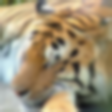

In [ ]:
def example_transformed(transform: Callable[[torch.Tensor], torch.Tensor], image_id: int = 510, seed: int = 42) -> None:
    torch.manual_seed(seed)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[image_id]
    with torch.no_grad():
        img = transform(img)
    display_image_tensor(img)


def benchmark_transform(transform: v2.Transform) -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
    dataset = Subset(dataset, range(2500))
    dataloader = get_dataloader(dataset, batch_size=256, num_workers=0)
    for _image_batch, _label_batch in tqdm(dataloader):
        pass


example_transformed(v2.GaussianBlur(kernel_size=25, sigma=2.0), 513)

#### 1a: Blur
Implement a transformation that blurs the image (any method that makes the image visually smoother in all directions is fine).<br>
The transform should be parameterized by strength (from roughly 1 meaning no/minimal blurring to 100 meaning the image becomes unrecognizable to humans).<br>
For task 1a specifically, do not use any library beyond `torch.*` and python built-ins (in particular, do not use `torchvision`'s `GaussianBlur`).<br>

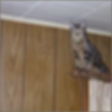

In [ ]:
def blur(x: torch.Tensor, strength: int = 10) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    *B, C, H, W = x.shape
    ### BEGIN SOLUTION
    # We are using Gaussian Kernel.
    kernel_size = int(1 + strength // 10) * 2 + 1
    sigma_squared = strength / 4

    t = torch.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size, dtype=x.dtype)
    kernel_1d = torch.exp(-0.5 * (t ** 2) / sigma_squared)
    kernel_1d /= kernel_1d.sum()
    kernel_2d = torch.outer(kernel_1d, kernel_1d).expand(C, 1, kernel_size, kernel_size)

    padding = kernel_size // 2

    x = F.conv2d(x, kernel_2d, padding=padding, groups=C)
    ### END SOLUTION
    return x


example_transformed(blur, 507)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(blur)]))

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


#### 1b: Pixelize
Implement a transformation that averages blocks of `block_height x block_width` pixels, as in the example below.

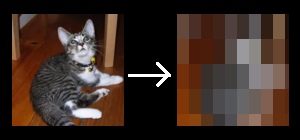

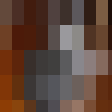

In [ ]:
def pixelize(x: torch.Tensor, block_height: int = 8, block_width: int = 8) -> torch.Tensor:
    assert 1 <= block_height and 1 <= block_width, f"Expected ≥1, got {block_height=}, {block_width=}."
    ### BEGIN SOLUTION
    *B, C, H, W = x.shape
    x = F.avg_pool2d(x, kernel_size=(block_height, block_width), ceil_mode=True)
    *b, c, h, w = x.shape

    x = x.reshape(-1, c, h, w)
    x = F.interpolate(x, size=(block_height * h,  block_width * w), mode='nearest')
    x = x[:, :, :H, :W]
    x = x.reshape(*B, C, H, W)
    ### END SOLUTION
    return x


example_transformed(lambda x: pixelize(x, 25, 12), 510)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(pixelize)]))

100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


#### 1c: Noise

Implement a transformation that adds noise (same on each channel, up to normalization constants) to an image.<br>
Any kind of noise like that is fine, but it should be parameterized by noise strength (from 1 unnoticeable to 100 unrecognizable) and grain size (roughly in pixels), as in the four examples below.<br>

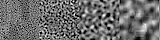

In [ ]:
def noise(x: torch.Tensor, strength: int = 25, grain_size: int = 10) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    assert 1 <= grain_size <= 100, f"Expected 1 ≤ grain_size ≤ 100, got {grain_size}."
    ### BEGIN SOLUTION
    *B, C, H, W = x.shape
    x = x.reshape(-1, C, H, W)
    batch_size = x.shape[0]

    noise = torch.randn(batch_size, 1, H // grain_size, W // grain_size) * strength / 100
    noise = F.interpolate(noise, size=(H, W), mode='bilinear', align_corners=False)

    x = normalize(torch.clamp(unnormalize(x) + noise, 0, 1))
    x = x.reshape(*B, C, H, W)
    ### END SOLUTION
    return x


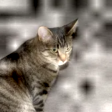

In [ ]:
example_transformed(noise, 506)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(noise)]))

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


## Task 2: Comparing augmentations

Focus on the readability of the presented results.

Note: to use transforms defined in a notebook, you will have to call `evaluate()` with `use_workers=False`<br>
(this is because functions are pickled by reference, and those defined in a notebook cannot be imported by workers spawned by a dataloader;<br>
other workarounds include writing a Python module e.g. with `%%writefile file.py`, or using the `cloudpickle` package, but we prefer to keep it simple here).

#### Side note: lambdas in for loops

Since in this task it may be useful to use lots of lambdas (to change default parameters in your transformations),<br>
we would like to warn about one potential pitfall here.<br>

One 'gotcha' in Python is that 'for' variables (and similar blocks) are not scoped to the loop body,<br>
they continue with the value from the last iteration.

In [ ]:
def example() -> None:
    for i in range(3):
        for j in range(3):
            pass
        print(j)


example()

2
2
2


This is sometimes useful and mostly benign, but we may overlook using the wrong variable.

Another gotcha is that closures in Python (lambdas or def-s using variables from external scopes)<br>
are *late-binding*, meaning variables are captured by reference,<br>
so especially together with the previous gotcha, we get a probably-not-so-intuitive result:

In [ ]:
def example() -> None:
    funcs = [(lambda x: x + a) for a in range(3)]
    for f in funcs:
        print(f(0))


example()

2
2
2


Use `lambda x, a=a: f(x,a)` or `functools.partial(f, a=a)` to capture by value instead.

(A linter like [ruff](https://docs.astral.sh/ruff/) will warn you about both gotchas, by detecting e.g. [unused loop variables](https://docs.astral.sh/ruff/rules/unused-loop-control-variable/) and [loop variables used in closures](https://docs.astral.sh/ruff/rules/function-uses-loop-variable/), unfortunately there is no easy way to use them in Colab).

#### 2a: On vanilla model

Compare how `get_model()` performs on inputs from the `val` dataset, when transformed with your transformations (one at a time) or with `v2.GaussianBlur`, using different transform parameters.
(Use each transformation after `get_eval_transform()`, as in the benchmarks above.)

Plot the results. The total time taken by computations for this subtask must not exceed 10 minutes (on Colab GPU)<br>
(use fewer than 100 calls to evaluate(); if running on CPU, expect less than 40 minutes).<br>
Discuss the results in 2-4 sentences.

In [ ]:
def evaluate_transform(model:torch.nn.Module | None, transform_func, device, param_list = [None], use_workers:bool = False):
    accuracies = []

    for param in param_list:
        if param is None:
            transform = v2.Compose([
                get_eval_transform(),
                transform_func
            ])
        else:
            transform = v2.Compose([
                get_eval_transform(),
                v2.Lambda(functools.partial(transform_func, param=param))
            ])

        dataset = ImageFolder(
            MINI_IMAGENET_PATH / "val",
            transform=transform
        )

        if model is None:
            model = get_model(eval=True)

        dataloader = get_dataloader(dataset=dataset, num_workers=0)
        accuracy = evaluate(model, dataloader, device=device, use_workers=use_workers)
        accuracies.append(accuracy)

    return accuracies

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

# 64 calls to evaluate()
blur_strengths = [5, 10, 15, 20, 30, 40, 60, 90]  # 8 calls to evaluate()
pixelate_block_sizes = [(2, 2), (4, 4), (6, 6), (8, 8), (10, 10), (16, 16), (24, 24), (32, 32)]  # 8 calls to evaluate()
noise_strengths = [5, 10, 15, 20, 30, 40, 60, 90]  # 8 values
noise_grain_sizes = [2, 4, 8, 16, 32]  # 5 values
noise_params = list(itertools.product(noise_strengths, noise_grain_sizes))  # 40 calls to evaluate()
gaussian_blur_sigmas = [0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0]  # 8 calls to evaluate()

def pixelize_transform(x, param):
    block_height, block_width = param
    return pixelize(x, block_height=block_height, block_width=block_width)

def blur_transform(x, param):
    return blur(x, strength=param)

def noise_transform(x, param):
    strenght, grain_size = param
    return noise(x, strenght, grain_size)

def gaussian_blur_transform(x, param):
    return v2.GaussianBlur(kernel_size=(5, 5), sigma=param)(x)

pixelize_accuracies = evaluate_transform(None, transform_func=pixelize_transform, param_list=pixelate_block_sizes, device=device)
blur_accuracies = evaluate_transform(None, transform_func=blur_transform, param_list=blur_strengths, device=device)
noise_accuracies = evaluate_transform(None, transform_func=noise_transform, param_list=noise_params, device=device)
gaussian_blur_accuracies = evaluate_transform(None, transform_func=gaussian_blur_transform, param_list=gaussian_blur_sigmas, device=device)

eval: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it, accuracy=76.9 %]


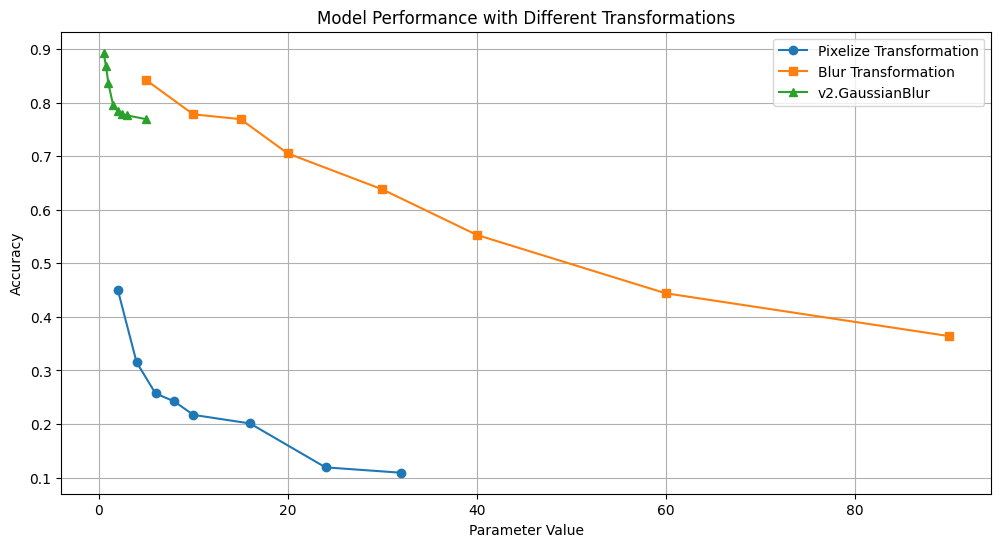

In [ ]:
plt.figure(figsize=(12, 6))

pixelate_plot_values = [bh for bh, _ in pixelate_block_sizes]

plt.plot(pixelate_plot_values, pixelize_accuracies, marker='o', label='Pixelize Transformation')
plt.plot(blur_strengths, blur_accuracies, marker='s', label='Blur Transformation')
plt.plot(gaussian_blur_sigmas, gaussian_blur_accuracies, marker='^', label='v2.GaussianBlur')
plt.xlabel('Parameter Value')
plt.ylabel('Accuracy')
plt.title('Model Performance with Different Transformations')
plt.legend()
plt.grid(True)
plt.show()

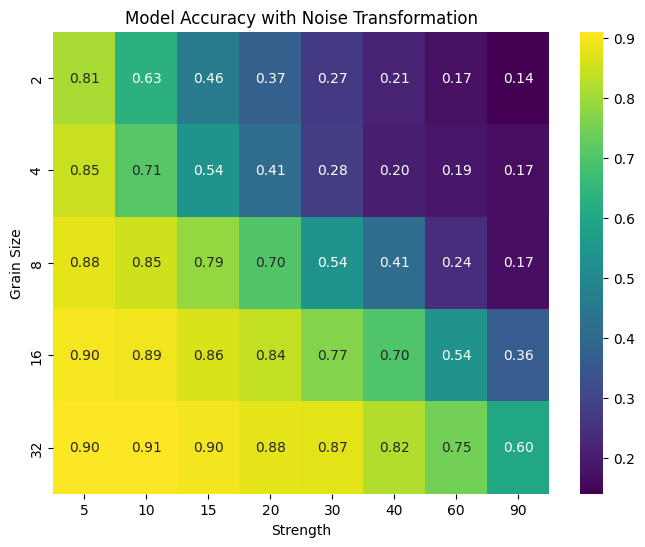

In [ ]:
df = pd.DataFrame(noise_params, columns=['Strength', 'Grain Size'])
df['Accuracy'] = noise_accuracies

pivot_df = df.pivot(index='Grain Size', columns='Strength', values='Accuracy')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='viridis')
plt.title('Model Accuracy with Noise Transformation')
plt.xlabel('Strength')
plt.ylabel('Grain Size')
plt.show()

**Conclusion:**

The results demonstrate that the model is not robust to all transformations, with pixelization, blure for large strenghts and high-strength, fine-grain noise having the most detrimental impact on accuracy (dropping as low as values between 0.5 and 0.1).

In contrast, Gaussian Blur and blur transformations at small strenght show only moderate effects, and low-strength, large-grain noise maintains good accuracy.

This suggests the model relies heavily on fine-grained details, making it vulnerable to transformations that significantly alter or obscure these features.

In [ ]:
### END SOLUTION

#### 2b: Fine-tuning

Consider the following set of transformations: `{v2.Identity(), noise(strength=25, grain_size=3), v2.GaussianBlur(kernel_size=7, sigma=5)}`.

Compare how models fine-tuned for 3 epochs with each augmentation from that set<br>
(one at a time, using `Trainer(extra_augmentation=..., n_epochs=3)`, with `use_workers=False` if `noise` is used)<br>
performs on val with each augmentation from that set, and on the alt dataset with zero augmentations.<br>
We don't expect computations to take more than 20 minutes in total, for this subtask (on Colab GPU; CPU is too slow for fine-tuning, ~20min per epoch).

Present the `3 x 4` results in a table. Discuss the results in 1-2 sentences.

In [ ]:
### BEGIN SOLUTION
def fine_tuning(transform_set, val_transform_set, device, n_epochs:int = 3):
    results = {}

    for train_transform in transform_set:
        model = get_model()
        use_workers = False if isinstance(train_transform, partial) and train_transform.func == noise_transform else True

        trainer = Trainer(
            extra_augmentation=train_transform,
            n_epochs=n_epochs,
            use_workers=use_workers,
            device=device
        )
        trainer.train(model)

        val_results = []
        for eval_transform in val_transform_set:
            accuracy = evaluate_transform(
                model=model,
                transform_func=eval_transform,
                device=device,
            )[0]
            val_results.append(accuracy)

        # alt dataset.
        dataloader = trainer.get_eval_dataloaders()["alt"]
        alt_accuracy = evaluate(model, dataloader, device=device, use_workers=use_workers)

        results[transform_to_name(train_transform)] = val_results + [alt_accuracy]

    columns = [transform_to_name(t) for t in val_transform_set] + ["alt (no augment)"]
    return pd.DataFrame(results, index=columns).transpose()

def transform_to_name(transform):
    if isinstance(transform, v2.Identity):
        return "Identity"
    if isinstance(transform, functools.partial):
        if transform.func == noise_transform:
            return f"Noise (params={transform.keywords.get('param', 'unknown')})"
    if isinstance(transform, v2.GaussianBlur):
        return f"GaussianBlur (σ={transform.sigma}, kernel={transform.kernel_size})"
    return str(transform)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transformations = [
    v2.Identity(),
    functools.partial(noise_transform, param=[25,3]),
    v2.GaussianBlur(kernel_size=7, sigma=5)
]

results = fine_tuning(
    n_epochs=3,
    transform_set=transformations,
    val_transform_set=transformations,
    device=device
)

val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [01:12<00:00,  1.09it/s, train-acc=82.6 %, lr=0.0002]


val=93.0 %	alt=50.6 %	


Train epoch   2: 100%|██████████| 79/79 [01:08<00:00,  1.15it/s, train-acc=87.7 %, lr=0.000194]


val=94.8 %	alt=50.7 %	


Train epoch   3: 100%|██████████| 79/79 [01:09<00:00,  1.14it/s, train-acc=88.5 %, lr=0.000188]


val=96.1 %	alt=51.3 %	


eval: 100%|██████████| 11/11 [00:12<00:00,  1.17s/it, accuracy=51.3 %]


val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [02:17<00:00,  1.75s/it, train-acc=67.8 %, lr=0.0002]


val=91.9 %	alt=52.9 %	


Train epoch   2: 100%|██████████| 79/79 [02:18<00:00,  1.75s/it, train-acc=75.1 %, lr=0.000194]


val=94.0 %	alt=54.3 %	


Train epoch   3: 100%|██████████| 79/79 [02:18<00:00,  1.75s/it, train-acc=77.9 %, lr=0.000188]


val=95.2 %	alt=52.5 %	


eval: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it, accuracy=52.5 %]


val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=74.7 %, lr=0.0002]


val=92.4 %	alt=51.2 %	


Train epoch   2: 100%|██████████| 79/79 [01:16<00:00,  1.04it/s, train-acc=82.0 %, lr=0.000194]


val=93.7 %	alt=53.8 %	


Train epoch   3: 100%|██████████| 79/79 [01:14<00:00,  1.06it/s, train-acc=83.4 %, lr=0.000188]


val=93.4 %	alt=55.0 %	


eval: 100%|██████████| 11/11 [00:12<00:00,  1.18s/it, accuracy=55.0 %]


In [ ]:
pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option("display.colheader_justify", "center")
display(results)

,Identity,"Noise (params=[25, 3])","GaussianBlur (σ=[5.0, 5.0], kernel=(7, 7))",alt (no augment)
Identity,0.961,0.533,0.793,0.513
"Noise (params=[25, 3])",0.952,0.745,0.803,0.525
"GaussianBlur (σ=[5.0, 5.0], kernel=(7, 7))",0.934,0.553,0.848,0.550


**Conclusion:**

Fine-tuning with Noise or Gaussian Blur augmentation achieves better accuracy on the alt dataset than Identity, with Noise showing the most robust performance by maintaining a balanced accuracy across all datasets. This suggests that introducing specific augmentations during training, such as Noise, may help the model generalize better to adversarial datasets.

In [ ]:
|### END SOLUTION

## Adversarial image modification with PGD

One method to improve robustness, other than augmentations, is to train on adversarial examples: images that are altered with small perturbations to fool the model.
Here's a typical implementation.

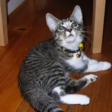

label=5 (cat)
Prediction: 5 (cat)


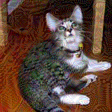

Prediction: 7 (clock)


In [ ]:
def adversarialPGD(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epsilon: float = 4 / 255,
    alpha: float = 2 / 255,
    n_iters: int = 1,
    random_init: bool = False,
) -> torch.Tensor:
    """
    Find an input xᵃᵈᵛ within x±ε pushing `model(xᵃᵈᵛ)` away from y (maximizing loss, unless alpha is negative).

    Uses 'Projective Gradient Descent' with learning rate `alpha` and `n_iters` iterations, as introduced in:
    Madry et al., "Towards Deep Learning Models Resistant to Adversarial Attacks", ICRL 2018
    https://openreview.net/forum?id=rJzIBfZAb

    Assumes x is 0..1-valued and keeps it in these bounds (i.e., it expects unnormalized images).
    """
    was_training = model.training
    model.eval()
    x = x.clone().detach()
    with torch.no_grad():
        x_min = torch.clamp(x - epsilon, min=0)
        x_max = torch.clamp(x + epsilon, max=1)

        if random_init:
            x = x + torch.empty_like(x).uniform_(-epsilon, epsilon)
            x.clamp_(x_min, x_max)

    for _ in range(n_iters):
        x.requires_grad = True
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)
        with torch.no_grad():
            x_grad = torch.autograd.grad(loss, x)[0]
            # We could also:
            #   loss.backward()
            #   x_grad = x.grad.detach()
            # but then we'd nedd to temporarily set requires_grad=False on all model parameters.
            x = x.detach() + alpha * x_grad.sign()
            x.clamp_(x_min, x_max)
            x = x.detach()

    if was_training:
        model.train()
    return x.requires_grad_(False)


def example(device="cuda") -> None:
    model = get_model(eval=True).to(device)

    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[510]
    display_image_tensor(img)
    print(f"{label=} ({dataset.classes[label]})")

    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    pred = model(img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")

    adv_img = normalize(adversarialPGD(model, unnormalize(img), label, epsilon=20 / 255, n_iters=100))
    display_image_tensor(adv_img[0])
    pred = model(adv_img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")


example()


## Task 3: AdvProp

Training on adversarial examples unfortunately tends to decrease accuracy on plain (unmodified) images a lot.<br>
The authors of [Adversarial Examples Improve Image Recognition](https://arxiv.org/abs/1911.09665) hypothesize that<br>
this is because adversarial examples (and the model activations they induce) follow different distributions.<br>
They propose addressing that by using auxilliary batch-norm-s for the adversarial images.

#### 3a: Implementation
Read the paper and implement this technique. Note that:
* Parameters (weights and biases of the affine transform applied after normalizing) should be the same for plain and adversarial images; only the running mean and variance (the buffers) are distinct.
* During evaluation, the plain batch-norms should be used.
* Add the two losses from plain and adversarial images using weights that sum up to one, specifically: `0.75 * plain_loss + 0.25 * adversarial_loss`.
* You should not need to alter this and other hyperparameters; use the defaults of `Trainer.__init__()` and `adversarialPGD` (they are different than suggested in the paper, but work better in our case).
* See `get_model()` for an example of how layers can be replaced. You can assume all batch-norms are instances of `torch.nn.BatchNorm2d` (with `affine=True`, `track_running_stats=True`, and non-null `momentum`).

In [ ]:
### BEGIN SOLUTION
class AdvBatchNorm(torch.nn.BatchNorm2d):
    def __init__(
        self,
        num_features: int,
        eps: float = 1e-5,
        momentum: float | None = 0.002,
        affine: bool = True,
        track_running_stats: bool = True
    ):
        super().__init__(
            num_features, eps=eps, momentum=momentum, affine=affine, track_running_stats=track_running_stats
        )
        self.register_buffer("running_mean_adv", torch.zeros(num_features))
        self.register_buffer("running_var_adv", torch.ones(num_features))
        self.register_buffer("running_mean_plain", torch.zeros(num_features))
        self.register_buffer("running_var_plain", torch.ones(num_features))
        self.use_adv_stats = False

    def forward(self, input: torch.Tensor):
        if self.training and self.use_adv_stats:
            self.running_mean = self.running_mean_adv
            self.running_var = self.running_var_adv
        else:
            self.running_mean = self.running_mean_plain
            self.running_var = self.running_var_plain

        return super().forward(input)

    def switch_to_plain_stats(self):
        self.use_adv_stats = False

    def switch_to_adv_stats(self):
        self.use_adv_stats = True

def replace_batch_norm_with_adv_batch_norm(model: torch.nn.Module) -> torch.nn.Module:
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            adv_bn = AdvBatchNorm(
                module.num_features,
                eps=module.eps,
                momentum=module.momentum,
                affine=module.affine,
                track_running_stats=module.track_running_stats,
            )
            if module.affine:
                adv_bn.weight.data = module.weight.data.clone()
                adv_bn.bias.data = module.bias.data.clone()
            adv_bn.running_mean_plain.data.copy_(module.running_mean)
            adv_bn.running_var_plain.data.copy_(module.running_var)

            parent_module = model
            for part in name.split('.')[:-1]:
                parent_module = getattr(parent_module, part)
            setattr(parent_module, name.split('.')[-1], adv_bn)
    return model
### END SOLUTION

In [ ]:
class AdvPropTrainer(Trainer):
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = "cuda",
        n_iters: int = 1,
        epsilon: float = 4 / 255,
        alpha: float = 2 / 255,
        adv_ratio: float = 0.25,
    ):
        super().__init__(
            lr=lr, weight_decay=weight_decay, batch_norm_momentum=batch_norm_momentum, n_epochs=n_epochs, device=device
        )
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.adv_ratio = adv_ratio

    ### BEGIN SOLUTION
    def train(self, model: torch.nn.Module):
        model = replace_batch_norm_with_adv_batch_norm(model)
        return super().train(model)

    def train_epoch(self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int):
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            optimizer.zero_grad()
            # New part of train_epoch().
            # Plain examples.
            for module in model.modules():
                if isinstance(module, AdvBatchNorm):
                    module.switch_to_plain_stats()
            logits_plain = model(image_batch)
            plain_loss = torch.nn.CrossEntropyLoss()(logits_plain, label_batch)

            # Adversarial examples.
            adv_batch = normalize(adversarialPGD(model, unnormalize(image_batch), label_batch, epsilon=self.epsilon, alpha=self.alpha, n_iters=self.n_iters))

            for module in model.modules():
                if isinstance(module, AdvBatchNorm):
                    module.switch_to_adv_stats()
            logits_adv = model(adv_batch)
            adv_loss = torch.nn.CrossEntropyLoss()(logits_adv, label_batch)

            # Loss.
            loss = (1- self.adv_ratio) * plain_loss + self.adv_ratio * adv_loss
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_plain.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})

    ### END SOLUTION

#### 3b: Evaluation

Compare Trainer and AdvPropTrainer (using default hyperparameters, 10 epochs, in particular).<br>
(One training with Trainer / AdvPropTrainer takes roughly 15 / 20 minutes on colab GPU, respectively).<br>
Discuss the results in 1-3 sentences (consider proposing what could be tested further, with more time).

In [ ]:
### BEGIN SOLUTION
device='cuda' if torch.cuda.is_available() else 'cpu'

trainer = Trainer(n_epochs=10, device=device)
model_trainer = get_model()
results_trainer = trainer.train(model_trainer)

advprop_trainer = AdvPropTrainer(n_epochs=10, device=device)
model_advprop_trainer = get_model()
results_advprop_trainer = advprop_trainer.train(model_advprop_trainer)

print("Results with Trainer:")
for dataset, acc_list in results_trainer.items():
    print(f"{dataset}: {acc_list[-1] * 100:.2f}%")

print("\nResults with AdvPropTrainer:")
for dataset, acc_list in results_advprop_trainer.items():
    print(f"{dataset}: {acc_list[-1] * 100:.2f}%")

val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [01:30<00:00,  1.15s/it, train-acc=64.7 %, lr=0.0002]


val=91.9 %	alt=55.3 %	


Train epoch   2: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=75.0 %, lr=0.000194]


val=90.9 %	alt=53.7 %	


Train epoch   3: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=78.0 %, lr=0.000188]


val=90.4 %	alt=52.8 %	


Train epoch   4: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, train-acc=79.4 %, lr=0.000183]


val=93.4 %	alt=54.7 %	


Train epoch   5: 100%|██████████| 79/79 [01:25<00:00,  1.09s/it, train-acc=80.5 %, lr=0.000177]


val=93.6 %	alt=54.9 %	


Train epoch   6: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, train-acc=81.5 %, lr=0.000172]


val=93.9 %	alt=55.6 %	


Train epoch   7: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, train-acc=82.1 %, lr=0.000167]


val=93.8 %	alt=55.5 %	


Train epoch   8: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, train-acc=82.9 %, lr=0.000162]


val=94.3 %	alt=54.6 %	


Train epoch   9: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=82.6 %, lr=0.000157]


val=94.0 %	alt=55.6 %	


Train epoch  10: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, train-acc=83.9 %, lr=0.000152]


val=95.0 %	alt=54.0 %	
val=90.3 %	alt=43.0 %	


Train epoch   1: 100%|██████████| 79/79 [01:41<00:00,  1.29s/it, train-acc=65.1 %, lr=0.0002]


val=91.4 %	alt=55.5 %	


Train epoch   2: 100%|██████████| 79/79 [01:37<00:00,  1.24s/it, train-acc=74.3 %, lr=0.000194]


val=91.3 %	alt=56.1 %	


Train epoch   3: 100%|██████████| 79/79 [01:38<00:00,  1.24s/it, train-acc=76.9 %, lr=0.000188]


val=91.8 %	alt=56.9 %	


Train epoch   4: 100%|██████████| 79/79 [01:36<00:00,  1.22s/it, train-acc=78.1 %, lr=0.000183]


val=92.1 %	alt=57.3 %	


Train epoch   5: 100%|██████████| 79/79 [01:38<00:00,  1.24s/it, train-acc=79.6 %, lr=0.000177]


val=92.6 %	alt=57.8 %	


Train epoch   6: 100%|██████████| 79/79 [01:34<00:00,  1.20s/it, train-acc=80.1 %, lr=0.000172]


val=93.4 %	alt=59.0 %	


Train epoch   7: 100%|██████████| 79/79 [01:38<00:00,  1.24s/it, train-acc=80.7 %, lr=0.000167]


val=94.0 %	alt=56.1 %	


Train epoch   8: 100%|██████████| 79/79 [01:37<00:00,  1.23s/it, train-acc=81.3 %, lr=0.000162]


val=93.3 %	alt=56.0 %	


Train epoch   9: 100%|██████████| 79/79 [01:37<00:00,  1.23s/it, train-acc=82.1 %, lr=0.000157]


val=92.8 %	alt=56.9 %	


Train epoch  10: 100%|██████████| 79/79 [01:37<00:00,  1.24s/it, train-acc=81.9 %, lr=0.000152]


val=93.1 %	alt=56.5 %	
Results with Trainer:
val: 95.00%
alt: 54.04%

Results with AdvPropTrainer:
val: 93.10%
alt: 56.54%


**Conclusion**:

In this iteration, the results show that while the AdvPropTrainer improves robustness to adversarial examples, achieving a higher adversarial accuracy (alt: 56.54%) compared to the standard Trainer (alt: 54.04%), it slightly underperforms on validation accuracy (val: 93.10% vs. 95.00%). This suggests a trade-off between adversarial robustness and general validation performance. Training for more epochs, fine-tuning the loss weight ratio, or exploring different adversarial perturbations or PGD with different perturbation size as mentioned in the paper might further improve overall performance and reveal if the model can generalize better.

In [ ]:
### END SOLUTION

## Task 4: SparseTopK

Another technique to improve robustness against style and pattern changes was proposed in
[Emergence of Shape Bias in CNNs through Activation Sparsity](https://openreview.net/forum?id=QzcZb3fWmW)
(you do not need to read the paper).
The idea is simple: in between some layers, enforce activation sparsity by zeroing out all but the top say 20% activations (by absolute value).
The hope is that the strong activations, which we keep, encode the more generalizable shape information.

More formally `SparseTopK`, for a fixed fraction $k$ like $20\%$, should be a module that for an input $x \in \mathbb{R}^{C \times H \times W}$ outputs:
$$ \begin{align*}
    x_{\text{out}}[c,h,w] &= x[c,h,w]\quad &&\text{ if } |x[c,h,w]| \geq \text{top-k-percentile}(x[c,:,:]) \\
                          &= 0 \quad &&\text{ otherwise}
\end{align*} $$

Your task is to:
* implement such a module below (for inputs of shape `(batch_size, C, H, W)`),
* run the example once (for 10 epochs),
* shortly discuss the result (one sentence).

In [ ]:
class SparseTopK(torch.nn.Module):
    def __init__(self, k: float):
        super().__init__()
        self.k = k
        assert 0 <= k <= 1, f"Expected 0 ≤ k ≤ 1, got {k}."

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### BEGIN SOLUTION
        batch_size, C, H, W = x.shape
        x_flat = x.view(batch_size, C, -1)

        k_percentile = int(self.k * H * W)
        if k_percentile == 0:
            return torch.zeros_like(x)

        threshold, _ = torch.kthvalue(x_flat.abs(),k=H * W - k_percentile + 1, dim=-1, keepdim=True)
        threshold = threshold.expand_as(x_flat)

        mask = (x_flat.abs() >= threshold).view_as(x)
        x = x * mask
        ### END SOLUTION
        return x


def example_sparse() -> None:
    model = get_model()
    # The paper tests on ResNet18 and suggests inserting one SparseTopK(0.2) module after the second layer.
    # We'll do something similar for our model, EfficientNetB0.
    model.features[1][0].block.insert(3, SparseTopK(0.2))

    Trainer().train(model)


example_sparse()

val=76.2 %	alt=31.5 %	


Train epoch   1: 100%|██████████| 79/79 [01:37<00:00,  1.23s/it, train-acc=51.8 %, lr=0.0002]


val=85.9 %	alt=52.2 %	


Train epoch   2: 100%|██████████| 79/79 [01:31<00:00,  1.15s/it, train-acc=63.6 %, lr=0.000194]


val=85.2 %	alt=53.0 %	


Train epoch   3: 100%|██████████| 79/79 [01:31<00:00,  1.16s/it, train-acc=67.9 %, lr=0.000188]


val=86.6 %	alt=55.1 %	


Train epoch   4: 100%|██████████| 79/79 [01:31<00:00,  1.16s/it, train-acc=69.9 %, lr=0.000183]


val=88.6 %	alt=54.9 %	


Train epoch   5: 100%|██████████| 79/79 [01:30<00:00,  1.15s/it, train-acc=71.8 %, lr=0.000177]


val=88.1 %	alt=54.9 %	


Train epoch   6: 100%|██████████| 79/79 [01:31<00:00,  1.15s/it, train-acc=73.0 %, lr=0.000172]


val=90.0 %	alt=54.6 %	


Train epoch   7: 100%|██████████| 79/79 [01:29<00:00,  1.13s/it, train-acc=74.2 %, lr=0.000167]


val=90.7 %	alt=53.4 %	


Train epoch   8: 100%|██████████| 79/79 [01:28<00:00,  1.12s/it, train-acc=75.1 %, lr=0.000162]


val=91.5 %	alt=54.5 %	


Train epoch   9: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it, train-acc=76.0 %, lr=0.000157]


val=90.8 %	alt=55.5 %	


Train epoch  10: 100%|██████████| 79/79 [01:29<00:00,  1.13s/it, train-acc=76.2 %, lr=0.000152]


val=91.1 %	alt=54.8 %	


`### BEGIN SOLUTION (discussion)`

The activation sparsity technique slightly improves robustness on the adversarial dataset compared to the Trainer model, but performs worse than the AdvProp model. However, the accuracy on the plain validation dataset is lower, which may be due to an insufficient number of epochs, as the training accuracy is only 76% and overfitting is unlikely.

`### END SOLUTION`